https://towardsdatascience.com/word2vec-with-pytorch-implementing-original-paper-2cd7040120b0

https://towardsdatascience.com/running-jupyter-notebook-on-the-cloud-in-15-mins-azure-79b7797e4ef6

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchtext.datasets import WikiText2
import pandas as pd
from nltk.corpus import brown
import numpy as np
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
import sys
from sklearn.manifold import TSNE
import plotly.graph_objects as go
import os
import random

In [2]:
def tensor_to_array(t):
    return np.array([i.item() for i in list(t)])

In [3]:
version = "april30_WT2_nodatalim_20epoch_64dim_50minf_2window"
vocab = torch.load(f"saves/vocab_{version}.pt")
len(vocab)

4078

In [4]:
from datasets import load_dataset
wikitext2 = load_dataset("wikitext", "wikitext-2-v1")
DATA_SPLIT = "train"
text = wikitext2[DATA_SPLIT]['text']
text = [item.lower().strip() for item in text if len(item) > 0]
len(text)
text = [item.split(" ") + ["\n"] for item in text if "=" not in item]

DATA_LIMIT = None #paragraph limit
all_words = []
for paragraph in text[:DATA_LIMIT]:
    all_words += paragraph
all_words = pd.Series(all_words)
# len(all_words)

print(sum(1 for i in all_words if i in vocab)/len(all_words))

/Users/samengel/Documents/Code/Simple Chatbot/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


0.8678133506400297


In [5]:
SCANNING_WINDOW = 2
#maybe need to split into paragraphs b/c different topics...
#returns context, middle word
def get_data(index, window, data):
    return list(data[index-window:index])+list(data[index+1:index+window+1]), data[index]

Start here for training...

In [6]:
folder = "train_data/"
version1 = "_data_"
version2 = "_wt2_window2_100minpf.pt"

In [26]:
x_test = torch.load(f"{folder}test{version1}x{version2}")

In [27]:
y_test = torch.load(f"{folder}test{version1}y{version2}")

In [28]:
x_train = torch.load(f"{folder}train{version1}x{version2}")
len(x_train) + len(x_test)

1766780

In [29]:
y_train = torch.load(f"{folder}train{version1}y{version2}")
len(y_train) + len(y_test)

1766780

In [30]:
import net as net_mod
from net import Net_CBOW, train_model
import importlib

In [47]:
EMBED_DIMENSION = 64
device = torch.device("cpu")
net = Net_CBOW(len(vocab), EMBED_DIMENSION)
net.to(device)

net.zero_grad()
criterion = nn.CrossEntropyLoss().to(device)
losses = []

In [48]:
# x_test = [torch.tensor(context).to(device) for context in x_test]
x_test = torch.tensor(x_test).to(device)
print("->")
# y_test = [torch.tensor(context).to(device) for context in y_test]
y_test = torch.tensor(y_test).to(device)
print("->")
# x_train = [torch.tensor(context).to(device) for context in x_train]
x_train = torch.tensor(x_train).to(device)
print("->")
# y_train = [torch.tensor(context).to(device) for context in y_train]
y_train = torch.tensor(y_train).to(device)

->
->
->


/var/folders/r4/fbbvmvd16633t8bw5262q18c0000gn/T/ipykernel_91130/1552445247.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_test = torch.tensor(x_test).to(device)
/var/folders/r4/fbbvmvd16633t8bw5262q18c0000gn/T/ipykernel_91130/1552445247.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(y_test).to(device)
/var/folders/r4/fbbvmvd16633t8bw5262q18c0000gn/T/ipykernel_91130/1552445247.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_train = torch.tensor(x_train).to(device)
/var/folders/r4/fbbvmvd16633t8bw526

In [49]:
NUM_EPOCHS = 20

# optimizer = optim.Adam(net.parameters(), lr=0.025)
# def optimizer_to(optim, device):
#     for param in optim.state.values():
#         # Not sure there are any global tensors in the state dict
#         if isinstance(param, torch.Tensor):
#             param.data = param.data.to(device)
#             if param._grad is not None:
#                 param._grad.data = param._grad.data.to(device)
#         elif isinstance(param, dict):
#             for subparam in param.values():
#                 if isinstance(subparam, torch.Tensor):
#                     subparam.data = subparam.data.to(device)
#                     if subparam._grad is not None:
#                         subparam._grad.data = subparam._grad.data.to(device)
# optimizer_to(optimizer, device)
# scheduler = optim.lr_scheduler.LinearLR(optimizer, 1.0, 0.0, total_iters=NUM_EPOCHS)

In [50]:
# batch_size = 1
# x_batches = np.array_split(np.array(x_train),len(x_train)//batch_size)

In [51]:
torch.__config__.show()

'PyTorch built with:\n  - GCC 4.2\n  - C++ Version: 201703\n  - clang 14.0.3\n  - OpenMP 201811\n  - LAPACK is enabled (usually provided by MKL)\n  - NNPACK is enabled\n  - CPU capability usage: NO AVX\n  - Build settings: BLAS_INFO=accelerate, BUILD_TYPE=Release, CXX_COMPILER=/Applications/Xcode_14.3.1.app/Contents/Developer/Toolchains/XcodeDefault.xctoolchain/usr/bin/c++, CXX_FLAGS= -fvisibility-inlines-hidden -DUSE_PTHREADPOOL -DNDEBUG -DUSE_KINETO -DLIBKINETO_NOCUPTI -DLIBKINETO_NOROCTRACER -DUSE_PYTORCH_QNNPACK -DUSE_XNNPACK -DUSE_PYTORCH_METAL_EXPORT -DSYMBOLICATE_MOBILE_DEBUG_HANDLE -DUSE_COREML_DELEGATE -O2 -fPIC -Wall -Wextra -Werror=return-type -Werror=non-virtual-dtor -Werror=braced-scalar-init -Werror=range-loop-construct -Werror=bool-operation -Wnarrowing -Wno-missing-field-initializers -Wno-type-limits -Wno-array-bounds -Wno-unknown-pragmas -Wno-unused-parameter -Wno-unused-function -Wno-unused-result -Wno-strict-overflow -Wno-strict-aliasing -Wvla-extension -Wsuggest-ove

In [ ]:
net = train_model("may1epochs", "may1_WT2_nodatalim_20epoch_64dim_100minpf_2window", x_train, y_train, x_test, y_test, net, criterion, NUM_EPOCHS)

In [52]:
# export OMP_NUM_THREADS=4
net = train_model("apr30epochs", "april30_WT2_nodatalim_20epoch_64dim_100minf_4window", x_train, y_train, x_test, y_test, net, criterion, NUM_EPOCHS)

RUN       •••••••••|•••••••••|•••••••••|•••••••••|•••••••••|•••••••••|•••••••••|•••••••••|•••••••••|•••••••••|
RUN 1/20: •••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••
RUN 2/20: •••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••
RUN 3/20: •••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••
RUN 4/20: •••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••
RUN 5/20: •••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••
RUN 6/20: •••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••
RUN 7/20: •••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••
RUN 8/20: •••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••

In [53]:
# torch.save(net, f"saves/model_{version}.pt")
# torch.save(vocab, f"saves/vocab_{version}.pt")

#Note that 4/26 20epoch version got to a loss of 10

In [54]:
loss_per_epoch = []
for i in range(NUM_EPOCHS):
    loss_per_epoch += [sum(losses[(i)*len(x_test):(i+1)*len(x_test)])/len(x_test)]

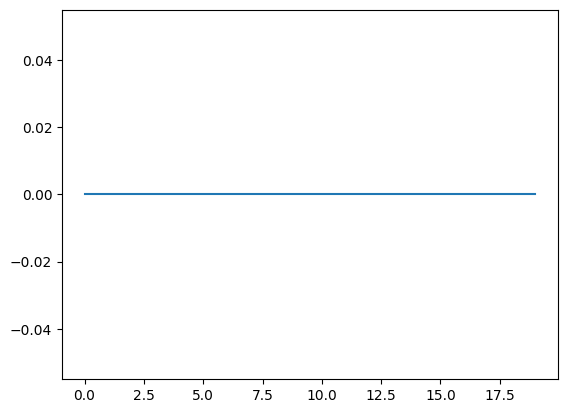

In [55]:
plt.plot(loss_per_epoch)
plt.show()

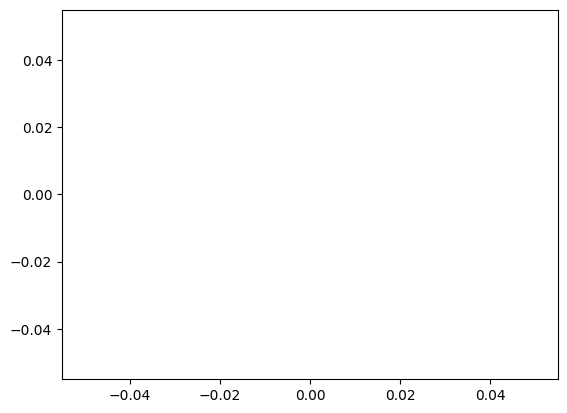

In [56]:
plt.plot(losses)
plt.show()

In [57]:
# get first layer of the model
embeddings = list(net.parameters())[0]
embeddings = embeddings.cpu().detach().numpy()

# normalize the embeddings layer
norms = (embeddings ** 2).sum(axis=1) ** (0.5)
norms = np.reshape(norms, (len(norms), 1))
embeddings_norm = embeddings / norms
embeddings_norm.shape

(4078, 64)

In [58]:
embeddings_df = pd.DataFrame(embeddings)

# t-SNE transform
tsne = TSNE(n_components=2)
embeddings_df_tsne = tsne.fit_transform(embeddings_df)
embeddings_df_tsne = pd.DataFrame(embeddings_df_tsne)

embeddings_df_tsne.index = vocab.keys()

In [59]:
numeric = embeddings_df_tsne.index.str.isnumeric()
color = np.where(numeric, "green", "gray")
fig = go.Figure()

fig.add_trace(
    go.Scatter(
        x=embeddings_df_tsne[0],
        y=embeddings_df_tsne[1],
        mode="text",
        text=embeddings_df_tsne.index,
        textposition="middle center",
        textfont=dict(color=color),
    )
)
fig.write_html("word2vec_visualization.html")
fig

In [60]:
def lookup_id(word, vocab=vocab):
    if word not in vocab:
        return vocab["<unk>"]
    return vocab[word]

In [61]:
def lookup_token(word_id, vocab=vocab):
    for word in vocab:
        if vocab[word] == word_id:
            return word
    return None

In [62]:
def get_top_similar(word: str, topN: int = 10):
    if word not in vocab:
        print("Out of vocabulary word")
        return
    word_id = lookup_id(word)

    word_vec = embeddings_norm[word_id]
    word_vec = np.reshape(word_vec, (len(word_vec), 1))
    dists = np.matmul(embeddings_norm, word_vec).flatten()
    topN_ids = np.argsort(-dists)[1 : topN + 1]

    topN_dict = {}
    for sim_word_id in topN_ids:
        # sim_word = vocab.lookup_token(sim_word_id)
        sim_word = "<unk_>"
        for k in vocab:
            if vocab[k] == sim_word_id:
                sim_word = k
                break
        topN_dict[sim_word] = dists[sim_word_id]
    return topN_dict

In [63]:
for word, sim in get_top_similar("1").items():
    print("{}: {:.3f}".format(word, sim))

manchester: 0.972
approved: 0.970
1968: 0.970
23: 0.969
6: 0.969
at: 0.969
illinois: 0.969
aid: 0.968
0: 0.968
7: 0.967


In [64]:
emb1 = embeddings[vocab["father"]]
emb2 = embeddings[vocab["man"]]
emb3 = embeddings[vocab["female"]]

emb4 = emb1 - emb2 + emb3
emb4_norm = (emb4 ** 2).sum() ** (1 / 2)
emb4 = emb4 / emb4_norm

emb4 = np.reshape(emb4, (len(emb4), 1))
dists = np.matmul(embeddings_norm, emb4).flatten()

top5 = np.argsort(-dists)[:5]

for word_id in top5:
    print("{}: {:.3f}".format(lookup_token(word_id), dists[word_id]))

badly: 0.971
flood: 0.971
egyptian: 0.969
interests: 0.969
paper: 0.967
